## This model version is used to train data from a glyphosate using data from the Hammamatsu spec sensor.
### Input data = 100 bands (50 from the dispersion spectrum + 50 from the emission spectrum)
### Number of samples at this point is 63 (in the range 0 to 1000 ppm) per group. Three groups of samples were obtained 1 on 10-17-25, and 2 on 10-18-25.

In [1]:
# Import modules
import os

# --- Step 1: Force CPU Usage (MUST be first) ---
# This ensures deterministic computations by avoiding the MPS GPU backend.
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
import random

# --- Step 2: Set All Random Seeds ---
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print("Forcing CPU-only execution for reproducibility. ✅")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler
# from tensorflow.keras.callbacks import EarlyStopping

import csv
# Misc
# from itertools import islice
# import plotly.express as px

Forcing CPU-only execution for reproducibility. ✅
Num GPUs Available:  0


## Inference functions


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

def apply_snv(X):
    """
    Aplica Standard Normal Variate (SNV) a un conjunto de espectros X.
    X debe tener la forma (n_muestras, n_bandas)
    """
    # Calcular media y std para cada muestra (fila)
    X_mean = np.mean(X, axis=1, keepdims=True)
    X_std = np.std(X, axis=1, keepdims=True)
    
    # Evitar división por cero si un espectro es plano
    X_std[X_std == 0] = 1.0
    
    # Aplicar SNV
    X_snv = (X - X_mean) / X_std
    return X_snv


def get_metrics(y_test,y_pred):
    # Evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    #r2 = r2_score(y_test, y_pred)
    regression_result = stats.linregress(y_test, y_pred)
    r2 = regression_result.rvalue ** 2

    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"R-squared (R2): {r2:.3f}")
    
    return(mae,rmse,r2)

def model_predict(dynamic_filename,X_test_scaled,y_test):
    # Load the saved model from the file
    print(f"Loading model from: {dynamic_filename}")
    loaded_model = tf.keras.models.load_model('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/Scripts/models/'+dynamic_filename)
    print("Model loaded successfully.")

    X_test = X_test_scaled
    # Use the loaded model to make predictions on the test data
    y_pred = loaded_model.predict(X_test)

    # The output of .predict() is often a 2D array, so we flatten it to a 1D array
    y_pred = y_pred.flatten()

    # LOD & LOQ
    is_blank = (y_test <0.001)
    y_pred_blanks = y_pred[is_blank]
    print(y_pred_blanks)
    mu_blank = np.mean(y_pred_blanks)
  
    sigma_blank = np.std(y_pred_blanks) 
    print(mu_blank,sigma_blank)
    lod = mu_blank + (3 * sigma_blank)
    loq = mu_blank + (10 * sigma_blank)

    print(f"(LOD): {lod:.4f} ppm")
    print(f"(LOQ): {loq:.4f} ppm")

    # Evaluation metrics
    mae,rmse,r2 = get_metrics(y_test,y_pred)
    
    # 2. Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Scatter plot of actual vs. predicted values
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolors="w", label='Predictions')

    # Add a line for perfect predictions (y=x)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Predictions')

    # 3. Add metrics to the plot
    # Using LaTeX for R^2
    metrics_text = (
        f"$R^2$ = {r2:.3f}\n"
        f"MAE = {mae:.3f}\n"
        f"RMSE = {rmse:.3f}"
    )
    # Place text box in the top-left corner
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    # 4. Final plot settings
    ax.set_xlabel("Actual Values (y_test)", fontsize=12)
    ax.set_ylabel("Predicted Values (y_pred)", fontsize=12)
    ax.set_title("Actual vs. Predicted Values", fontsize=16)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

### Read main file with samples

In [3]:
# Create augmentations with original data

# File path with measurements 
# file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/10-21-2025_G1_R3.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G1G2R1.csv'
# Open file with data.
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    data = []
    for i,row in enumerate(reader):
        data.append(row)
        # if n<1015:
        #     data.append(row)
        # n+=1
#len(data)

split = [] # The data from '10-21-2025_G1_R1.csv' will only be used for training and validation
split.append(len(data)) # original samples
split.append(len(data)) # train and val set
split.append((len(data)*0.2)/len(data)) # val set percentage
split.append(0) # test set

# Shuffle the rows of the data list in-place
random.shuffle(data)

print(len(data))
print(split)


261
[261, 261, 0.2, 0]


### Augmentations for training data

In [4]:
# Create augmentations with original data

# File path with measurements; group one with one sample per concentration, three replicate measurements
# file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/10-21-2025_G1_R3.csv'
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G1G2R1.csv'

# Create list variables
nombres = []
invalues = []
outvalues = []

# Create list for augmentations
filaau = ["A"] * 110
aug = []

variants = 7 # 7 m
noise1 = 0.06 # 0.05
noise2 = 0.03 # 0.02
# noise1b = -0.05
# noise2b = -0.02
# Open file with data
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    for row in reader:
        if n<(split[1]-1):
            filaau[1]=row[1] # row[1] is glyphosate concentration (true)
        # Start augmentations 
            # +-X% noise augmentation (m variants per sample)
            for j in range(0,variants):
              filaau[0]=row[0]+"_"+ str(j) # filaau contains string name sample + j-index (m variants j-indices per row/sample).
              # first block of x data
              for i in range(3,53): # Iterate over column 3 to 53 in csv per j iteration (m variants j-indices)
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise1, 1-noise1)
                #filaau[i] = filaau[i] + random.uniform(-noise1, noise1)
              filaau[53]='-'
              # second block of x data
              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise1, 1-noise1)
              # # Save augmentation
              aug.append(filaau.copy())

            #+-X noise augmentations%
            for j in range(variants,variants*2):
              filaau[0]=row[0]+"_"+ str(j)
              for i in range(3,53):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise2, 1-noise2)
              filaau[53]='-'
              # Second block of data
              for i in range(54,104):
                filaau[i]=float(row[i])
                filaau[i]=filaau[i]*random.uniform(1-noise2, 1-noise2)
              aug.append(filaau.copy())
        n+=1
len(data), split[1], len(aug)

(261, 261, 3640)

## X and y data

In [5]:
# X and y data lists
_inputs = []
_targets = []

# Add first block of data (original)
for i in range(int(split[1])):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                        row_data.append(float(data[i][j]))
        _inputs.append(row_data)
        _targets.append(float(data[i][1]))
# Add second block of data (augmentations for main and second file)
for i in range(len(aug)):
        row_data = []
        for j in range(3,104):
                if j!= 53:                        
                        row_data.append(float(aug[i][j]))
        _inputs.append(row_data)
        _targets.append(float(aug[i][1]))

# Convert list to arrays
X_data = np.array(_inputs)
y_data= np.array(_targets)

print(len(X_data), len(y_data))
print(len(data))
print(len(X_data[0]))

#X_data_limpio = apply_snv(X_data)
X_data_limpio=X_data
# Data normalization
#scaler = StandardScaler()
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_data_limpio)
print(split[2])

3901 3901
261
100
0.2


## Use PCA (95%

In [6]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


# print(f"Forma original de X_data: {X_data.shape}")
# print(f"Forma original de y_data: {y_data.shape}")
# print("-" * 30)

# --- 4. Aplicar PCA ---
# Inicializa PCA. n_components=0.95 le dice a PCA que
# seleccione automáticamente el número de componentes
# que explican el 95% de la varianza.
pca = PCA(n_components=0.95)

# Ajusta PCA SÓLO en los datos de entrenamiento escalados
X_train_pca = pca.fit_transform(X_data)

# --- 5. Revisar los resultados ---
print(f"Forma de X_train original (escalada): {X_data.shape}")
print(f"Forma de X_train reducida (PCA): {X_train_pca.shape}")
print("-" * 30)
print(f"Número de componentes seleccionados: {pca.n_components_}")
print(f"Varianza total explicada: {np.sum(pca.explained_variance_ratio_):.4f}")

# --- Listo para entrenar ---
print("\n¡Datos listos para el entrenamiento!")
print("Datos de entrenamiento: X_train_pca, y_train")
print("Datos de prueba: X_test_pca, y_test")

# AHORA puedes usar X_train_pca y y_train para entrenar tu modelo.
# Por ejemplo:
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression()
# model.fit(X_train_pca, y_train)
# accuracy = model.score(X_test_pca, y_test)
# print(f"Precisión del modelo en datos PCA: {accuracy:.4f}")

# Data normalization
#scaler = StandardScaler()
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)

import time

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_scaled, y_data, test_size=split[2], random_state=42
)

# Model definition
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(len(X_train[0]),)), # origianl sequence: 64,64,8,1
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='linear')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # original value: 0.009

# Optimizer and loss              
model.compile(optimizer=adam_optimizer,
              loss='mean_absolute_error',
              metrics=['mae'])
              #loss='mean_squared_error',
              #metrics=['mse'])

# Model training
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64, # original: 32
    validation_data=(X_val, y_val),
    verbose=1
)

# Get the last validation loss from the training history
final_val_loss = history.history['val_loss'][-1]

# Get the current date and time
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Create a descriptive filename using an f-string
dynamic_filename = f"model_loss-{final_val_loss:.4f}_{timestamp}.keras"

# Save the model with the new dynamic name
model.save('/Users/andresmr/Documents/Glyphosate_sensor_CFATA/Scripts/models/'+dynamic_filename)

# Print the name to see what was saved
print(f"Model saved successfully as: {dynamic_filename}")



Forma de X_train original (escalada): (3901, 100)
Forma de X_train reducida (PCA): (3901, 2)
------------------------------
Número de componentes seleccionados: 2
Varianza total explicada: 0.9519

¡Datos listos para el entrenamiento!
Datos de entrenamiento: X_train_pca, y_train
Datos de prueba: X_test_pca, y_test
Epoch 1/100


/opt/miniconda3/envs/gly_models/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 505.5657 - mae: 505.5657 - val_loss: 500.6196 - val_mae: 500.6196
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 486.4895 - mae: 486.4895 - val_loss: 458.0450 - val_mae: 458.0450
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 401.0979 - mae: 401.0979 - val_loss: 321.8425 - val_mae: 321.8425
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 254.0617 - mae: 254.0617 - val_loss: 227.0126 - val_mae: 227.0126
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 202.2635 - mae: 202.2635 - val_loss: 199.9818 - val_mae: 199.9818
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 183.3115 - mae: 183.3115 - val_loss: 188.9559 - val_mae: 188.9559
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 176.8398 - mae: 176.8398 - val_loss: 185.2854 - val_mae: 185.2854
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 174.5140 - mae: 174.5140 - val_loss: 183.7765 - val_mae: 183.776

131 131 100
Loading model from: model_loss-128.4636_20251114-094218.keras
Model loaded successfully.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[272.02795 252.84627 285.1473  184.25279 299.17218 590.5295 ]
313.996 129.00688
(LOD): 701.0166 ppm
(LOQ): 1604.0648 ppm
Mean Absolute Error (MAE): 159.131
Root Mean Squared Error (RMSE): 204.239
R-squared (R2): 0.683


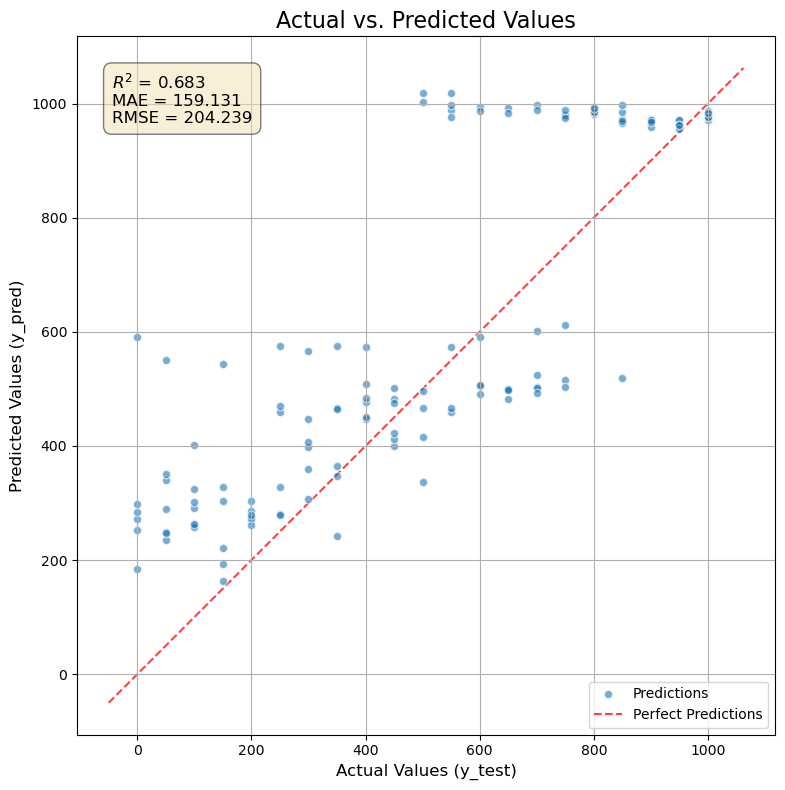

In [7]:
# INFERENCE ON TEST SET

# File path with measurements 
file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/samples/G2R2R3.csv'
#file_path = '/Users/andresmr/Documents/Glyphosate_sensor_CFATA/ESP32_code/samples/G2.csv'


# Open file with data. 
with open(file_path, 'r') as file:
    reader = csv.reader(file)
    n = 0
    test_data = []
    for i,row in enumerate(reader):
        test_data.append(row)
        # if n>=int(split[1]-1):
        #     test_data.append(row)
        # n+=1

_test_inputs = []
_test_targets = []

# Add first block of data (original)
for i in range(len(test_data)):
        row_data = []
        for j in range(3,104):
                if j!= 53:
                #if j>53:                       
                        row_data.append(float(test_data[i][j]))
        _test_inputs.append(row_data)
        _test_targets.append(float(test_data[i][1]))

# Convert list to arrays
X_test = np.array(_test_inputs)
y_test= np.array(_test_targets)

print(len(X_test), len(y_test), len(X_test[0]))

# Aplica la MISMA transformación PCA a los datos de prueba escalados
X_test_pca = pca.transform(X_test)

X_test_scaled = scaler.transform(X_test_pca)  # Note: just .transform(), not .fit_transform()

model_predict(dynamic_filename,X_test_scaled,y_test)
